In [62]:
import xarray as xr
import numpy as np
from tqdm import tqdm

In [63]:
flds = xr.open_dataset("./all-fields.nc")

In [64]:
flds

<xarray.Dataset>
Dimensions:    (t: 4000, x: 32)
Coordinates:
  * t          (t) float64 0.0 0.5 1.0 1.5 ... 1.998e+03 1.999e+03 2e+03
  * x          (x) float64 0.2641 0.7924 1.321 1.849 ... 15.05 15.58 16.11 16.64
Data variables:
    force-(x)  (t, x) float64 ...

In [65]:
xax = flds.coords["x"].data
tax = flds.coords["t"].data

dx = xax[1]-xax[0]
xmax = xax[-1] + dx/2.
dt = tax[1]-tax[0]

nv_part = 128
nx_part = xax.size

# initialize particles
xi = np.repeat(xax, nv_part)
vi = np.tile(np.linspace(-6, 6, nv_part), nx_part)

In [66]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'v ($v_{th}$)')

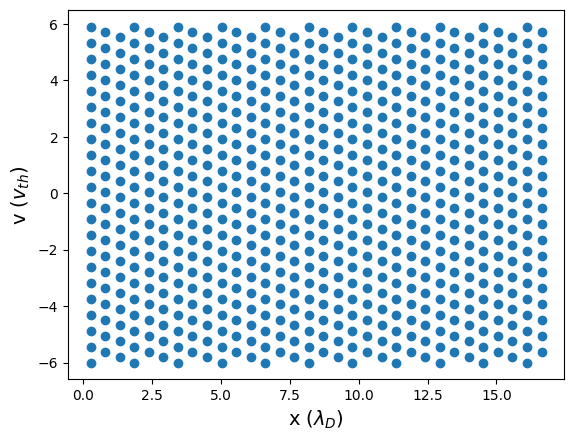

In [137]:
plt.scatter(xi[::6], vi[::6])
plt.xlabel("x ($\lambda_D$)", fontsize=14)
plt.ylabel("v ($v_{th}$)", fontsize=14)

In [68]:
nt = 2000
xp = np.zeros((nt, xi.size))
vp = np.zeros((nt, vi.size))

In [70]:
padded_x = np.concatenate([xax[0:1]-dx, xax, xax[-1:]+dx])
for it, tt in tqdm(enumerate(tax[:nt])):

    # initialize (this should just be done outside the loop)
    if it == 0:
        xp[it] = xi + dt * vi
        # padded_fld = np.concatenate([flds["force-(x)"][it].data[-1:], flds["force-(x)"][it].data, flds["force-(x)"][it].data[0:1]])
        # fp = np.interp(xp[it], padded_x, padded_fld)
        fp = np.interp(xp[it], xax, flds["force-(x)"][it].data, period=xmax)
        vp[it] = vi + dt * fp
    else:
        xp[it] = xp[it-1] + dt * vp[it-1]
        fp = np.interp(xp[it], xax, flds["force-(x)"][it].data, period=xmax)
        # padded_fld = np.concatenate([flds["force-(x)"][it].data[-1:], flds["force-(x)"][it].data, flds["force-(x)"][it].data[0:1]])
        # fp = np.interp(xp[it], padded_x, padded_fld)
        vp[it] = vp[it-1] + dt * fp

    # boundary condition
    xp = np.where(xp > xmax, xp - xmax, np.where(xp < 0, xp + xmax, xp))

2000it [01:10, 28.25it/s]


In [141]:
def sample_trajectories(n_traj):
    ipart = np.random.choice(np.arange(xi.size), n_traj, replace=False)
    for ip in ipart:
        plt.plot(vp[:, ip])
    plt.grid()
    plt.ylabel("v ($v_{th}$)", fontsize=14)
    plt.xlabel("t ($\omega_p^{-1}$)", fontsize=14)
    plt.title("Sample Velocity Trajectories", fontsize=16)
    

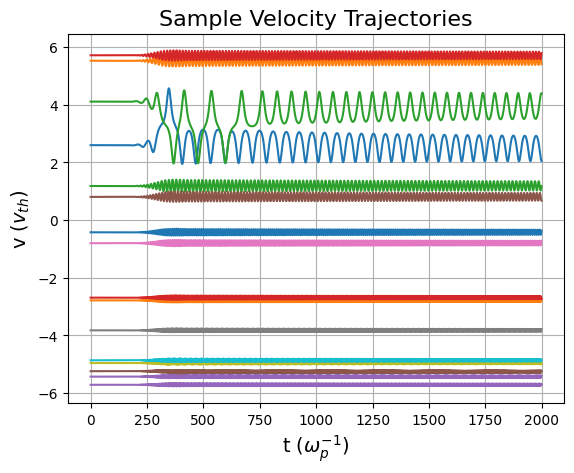

In [142]:
sample_trajectories(16)